
<table>
    <tr>
        <td><img src="https://s3.amazonaws.com/media-p.slid.es/uploads/1485763/images/9060062/Header.png" width="300"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="font-size:50%;color:blue;text-align:center">    <FONT COLOR="blue">  
            Detección de texto sensible </p> desde el usuario hacia el LLM        </FONT>         </h1>
        </td>         
        <td>
            <tp><p style="font-size:99%;text-align:center">  </p> ARQUITECTURA DE PROTECCIÓN DE PRIVACIDAD  </p> DE DATOS PARA MODELOS DE LENGUAJE DE GRAN TAMAÑO (LLM) USANDO CHATGPT </p></tp>
            <tp><p style="font-size:115%;text-align:center">Maestría MACC 2025</p></tp>
            <tp><p style="font-size:115%;text-align:center">Sofia Bonilla - Danna Ocampo - Daniel Lopez - Pedro Wightman</p></tp>
        </td>
    </tr>
</table>




<FONT SIZE=4 COLOR="green"> Instalación de bibliotecas y herramientas necesarias



<FONT SIZE=2 COLOR="black"> -> transformers:
Es una biblioteca de Hugging Face que proporciona modelos preentrenados para tareas de procesamiento de lenguaje natural (NLP)

<FONT SIZE=2 COLOR="black"> -> openai: Esta es la biblioteca oficial de OpenAI que permite interactuar con los modelos de OpenAI, como GPT

<FONT SIZE=2 COLOR="black"> -> datasets: Esta blioteca es muy útil para gestionar datasets en proyectos de procesamiento de lenguaje natural (NLP)

In [ ]:
!pip install transformers datasets
!pip install openai==0.28
!pip install datasets

<FONT SIZE=4 COLOR="green"> Importación de bibliotecas

In [ ]:
import pandas as pd  # Manejo de datos en estructuras tipo DataFrame
import torch  # Operaciones con tensores y computación en GPU
from sklearn.model_selection import train_test_split  # División de datos en entrenamiento/prueba
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification  # Tokenizador y modelo DistilBERT
from transformers import Trainer, TrainingArguments  # Configuración y entrenamiento de modelos
import re  # Procesamiento de texto con expresiones regulares
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc  # Evaluación de métricas
from datasets import Dataset  # Manipulación de conjuntos de datos
import matplotlib.pyplot as plt  # Visualización de gráficos
import seaborn as sns  # Gráficos estadísticos y visualización
from sklearn.preprocessing import label_binarize  # Preprocesamiento de etiquetas para clasificación
import openai  # Interacción con la API de OpenAI


<FONT SIZE=4 COLOR="green"> API Key de OPENAI

In [ ]:
openai.api_key = 'sk-proj-QmMFnqijmb98iKSWmcF5T3BlbkFJySuWHSxZ0wNhJcfKP0xn'

<FONT SIZE=4 COLOR="green"> Carga de datos en formato csv

In [ ]:
df = pd.read_csv('datos.csv')
print(df.head(10)) #Muestra las 10 primeras filas del dataset

                                                text  label
0  Mi nombre es Juan Pérez y mi correo es juan.pe...      1
1  El número de mi tarjeta de crédito es 1234-567...      1
2               La reunión es el viernes a las 3 PM.      0
3                                Mi ID es 123456789.      1
4              La fecha de nacimiento es 01/01/1990.      1
5                No tengo información sensible aquí.      0
6                           Mi teléfono es 555-1234.      1
7               El número de mi cuenta es 987654321.      1
8        Puedes contactar a María en maria@mail.com.      1
9      Mi tarjeta de crédito es 4321-8765-1234-5678.      1


<FONT SIZE=4 COLOR="green"> División de datos

Se dividen los datos en conjuntos de entrenamiento y prueba, usando un 80% para entrenamiento y 20% para prueba.

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'].tolist(), df['label'], test_size=0.2)

<FONT SIZE=4 COLOR="green"> Tokenización

*  DistilBertTokenizer: Es una clase de Hugging Face que convierte texto en una secuencia de tokens (números) que el modelo DistilBERT puede procesar.
*  from_pretrained('distilbert-base-uncased'): Carga el tokenizador asociado al modelo preentrenado distilbert-base-uncased.
*  distilbert-base-uncased: Significa que el texto de entrada se convertirá todo a minúsculas y no distinguirá entre mayúsculas y minúsculas.






Se inicializa el tokenizador para el modelo DistilBERT y se tokenizan los textos de entrenamiento y prueba.

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


La clase SensitiveDataDataset define un conjunto de datos personalizado para PyTorch, que convierte las codificaciones (encodings) y etiquetas (labels) en tensores, facilitando su uso en DataLoaders para entrenamiento y evaluación en lotes. Los métodos __getitem__ y __len__ permiten acceder a elementos individuales y conocer la longitud del conjunto de datos.

In [ ]:
class SensitiveDataDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SensitiveDataDataset(train_encodings, train_labels.tolist())
test_dataset = SensitiveDataDataset(test_encodings, test_labels.tolist())

<FONT SIZE=4 COLOR="green"> Configuración del modelo

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<FONT SIZE=4 COLOR="green">Entrenamiento del modelo

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',  # Directorio donde se guardarán los resultados.
    num_train_epochs=4,  # Número de épocas de entrenamiento (pasadas completas por los datos).
    per_device_train_batch_size=4,  # Tamaño del lote por dispositivo durante el entrenamiento.
    per_device_eval_batch_size=4,  # Tamaño del lote por dispositivo durante la evaluación.
    warmup_steps=500,  # Cantidad de pasos de calentamiento para ajustar la tasa de aprendizaje.
    weight_decay=0.01,  # Factor de decaimiento del peso para regularización (evita el overfitting).
    logging_dir='./logs',  # Directorio donde se guardarán los registros de entrenamiento.
    logging_steps=10,  # Frecuencia (en pasos) con la que se registrarán los logs de entrenamiento.
)

trainer = Trainer(
    model=model,  # Modelo que será entrenado (DistilBERT).
    args=training_args,  # Argumentos definidos previamente para el entrenamiento.
    train_dataset=train_dataset,  # Conjunto de datos para entrenamiento.
    eval_dataset=test_dataset,  # Conjunto de datos para evaluación.
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: sofia-06-bonilla (sofia-06-bonilla-universidad-del-rosario). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss
10,0.702500
20,0.679900
30,0.654000
40,0.628800
50,0.584200
60,0.559400
70,0.462200
80,0.430200
90,0.354300
100,0.323500


TrainOutput(global_step=672, training_loss=0.22234894947559086, metrics={'train_runtime': 1207.7387, 'train_samples_per_second': 2.219, 'train_steps_per_second': 0.556, 'total_flos': 20108137155360.0, 'train_loss': 0.22234894947559086, 'epoch': 4.0})

<FONT SIZE=4 COLOR="green">Evaluación del modelo -> Métricas

In [ ]:
# Guardar el modelo después del entrenamiento
trainer.save_model("./results")

# Cargar el dataset de validación
df_validation = pd.read_csv('validacion.csv')

# Verificar que 'frase' contiene texto y 'etiqueta' tiene valores numéricos
df_validation['frase'] = df_validation['frase'].astype(str)  # Asegurarse de que las frases sean cadenas
df_validation['etiqueta'] = df_validation['etiqueta'].astype(int)  # Asegurarse de que las etiquetas sean enteros

# Cargar el tokenizador y el modelo previamente entrenado
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('./results')  # Ruta donde guardaste el modelo entrenado

# Preprocesar el conjunto de validación
validation_encodings = tokenizer(df_validation['frase'].tolist(), truncation=True, padding=True, max_length=128)

# Convertir las etiquetas a tensores de torch
validation_labels = torch.tensor(df_validation['etiqueta'].values)

# Crear el dataset de validación para Hugging Face
validation_dataset = Dataset.from_dict({
    'input_ids': validation_encodings['input_ids'],
    'attention_mask': validation_encodings['attention_mask'],
    'labels': validation_labels
})

# Configurar el Trainer solo para evaluación
trainer = Trainer(model=model)

# Evaluar en el conjunto de validación
predictions = trainer.predict(validation_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)

# Generar y mostrar el informe de clasificación
print("Informe de clasificación en el conjunto de validación:")
print(classification_report(validation_labels, predicted_labels))


Informe de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       250
           1       0.82      0.80      0.81       250

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



<FONT SIZE=4 COLOR="green">Evaluación del modelo -> Gráficas

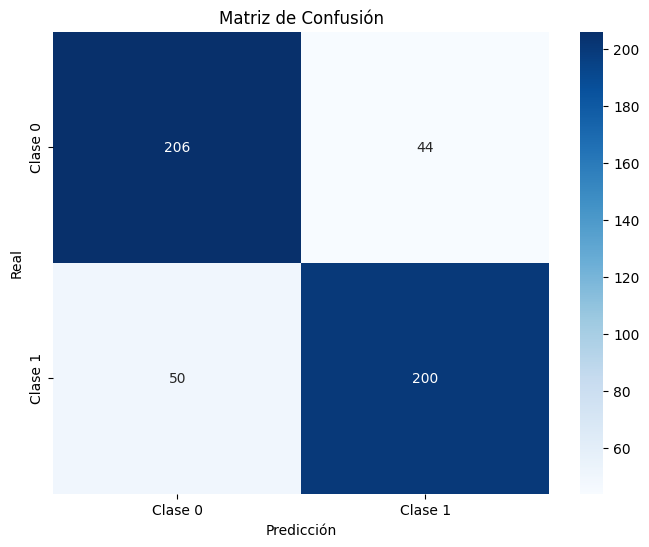

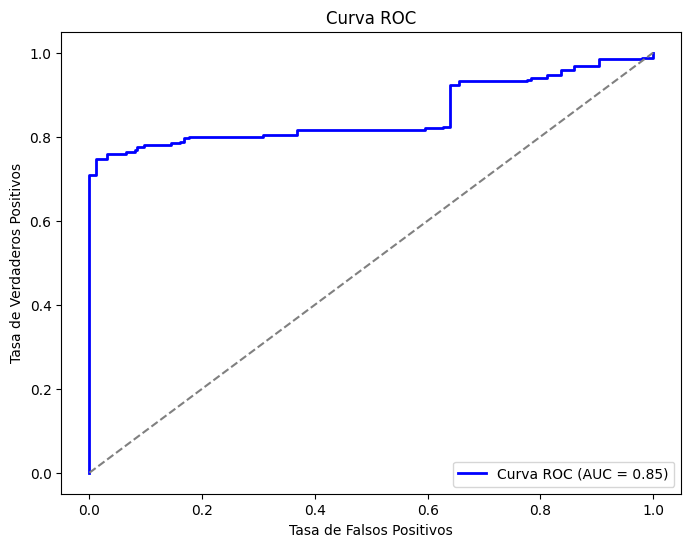

In [ ]:
# Matriz de Confusión
conf_matrix = confusion_matrix(validation_labels, predicted_labels)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Curva ROC y AUC (Área Bajo la Curva)
# Binarizamos las etiquetas
validation_labels_bin = label_binarize(validation_labels, classes=[0, 1])

# Calcular las probabilidades de predicción de cada clase
predicted_probs = predictions.predictions[:, 1]  # Probabilidades de la clase positiva (1)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(validation_labels_bin, predicted_probs)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

<FONT SIZE=4 COLOR="green"> Función de detección para patrones especificos

La función detect_sensitive_info(text) busca patrones específicos en un texto para identificar información sensible, como correos electrónicos, números de tarjetas de crédito, teléfonos, identificaciones, direcciones, fechas de nacimiento, datos médicos o bancarios. Utiliza expresiones regulares (re.search) para detectar cada uno de estos patrones y devuelve True si encuentra algún dato sensible; de lo contrario, retorna False.

In [ ]:
def detect_sensitive_info(text):
    # Detectar correo electrónico
    email_pattern = r'\b\w+@\w+\.\w+\b'
    if re.search(email_pattern, text):
        return True

    # Detectar tarjeta de crédito
    credit_card_pattern = r'\b\d{4}[- ]?\d{4}[- ]?\d{4}[- ]?\d{4}\b'
    if re.search(credit_card_pattern, text):
        return True

    # Detectar número de teléfono
    phone_pattern = r'\b\d{1,3}[- ]?\d{1,3}[- ]?\d{1,4}\b'
    if re.search(phone_pattern, text):
        return True

    # Detectar números de identificación (DNI, SSN, etc.)
    id_pattern = r'\b\d{8,9}\b'  # Ejemplo de DNI o SSN (ajustar según el formato necesario)
    if re.search(id_pattern, text):
        return True

    # Detectar direcciones (muy simplificado, solo para ejemplos)
    address_pattern = r'\b\d+\s\w+\s\w+\b'  # Ejemplo básico para detección de direcciones
    if re.search(address_pattern, text):
        return True

    # Detectar fechas de nacimiento (formato DD/MM/YYYY o similar)
    dob_pattern = r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b'
    if re.search(dob_pattern, text):
        return True

    # Detectar datos médicos (ejemplo: números de historia clínica)
    medical_record_pattern = r'\b\d{10,12}\b'  # Número de historia clínica
    if re.search(medical_record_pattern, text):
        return True

    # Detectar datos financieros (número de cuenta bancaria)
    bank_account_pattern = r'\b\d{10,12}\b'  # Número de cuenta bancaria (ajustar según el formato)
    if re.search(bank_account_pattern, text):
        return True

    # Si no se detecta información sensible
    return False

<FONT SIZE=4 COLOR="green"> Función de ofuscación

La función obfuscate(text) está diseñada para ofuscar (es decir, ocultar parcialmente) información sensible dentro de un texto, mientras se mantiene visible una parte relevante de los datos. Esto se logra mediante el uso de expresiones regulares para encontrar patrones específicos.

In [ ]:
def obfuscate(text):
    # Ofuscar números de tarjeta de crédito (manteniendo los últimos 4 dígitos)
    text = re.sub(r'\b(\d{4})([- ]?\d{4}){3}\b', lambda m: f"{m.group(1)}-****-****-{m.group(0)[-4:]}", text)

    # Ofuscar números de teléfono (manteniendo los últimos 4 dígitos)
    text = re.sub(r'\b(\d{1,3})[- ]?(\d{1,3})[- ]?(\d{1,4})\b', lambda m: f"****-****-{m.group(3)}", text)

    # Ofuscar correos electrónicos (manteniendo el primer carácter y el dominio visible)
    text = re.sub(r'(\w)(\w+?)(@\w+\.\w+)', lambda m: f"{m.group(1)}{'*' * len(m.group(2))}{m.group(3)}", text)

    # Ofuscar contraseñas (debe estar precedida por "contraseña" o "clave")
    text = re.sub(r'\b(?:contraseña|clave):?\s*(\w{6,})\b', lambda m: f"{m.group(0).split(':')[0]}: {obfuscate_password(m.group(1))}", text)

    # Ofuscar números (manteniendo parte visible, excepto si están junto a "número")
    text = re.sub(r'\b(?!número)(\d+)\b', lambda m: obfuscate_number(m.group(0)), text)

    return text

def obfuscate_password(password):
    length = len(password)
    if length <= 2:
        return password  # No ofuscar si es muy corto
    keep_count = max(1, length // 5)  # Mantener al menos el 20%
    obfuscated = '*' * (length - keep_count) + password[-keep_count:]
    return obfuscated

def obfuscate_number(number):
    length = len(number)
    if length <= 2:
        return number  # No ofuscar si es muy corto
    keep_count = max(1, length // 5)  # Mantener al menos el 20%
    obfuscated = '*' * (length - keep_count) + number[-keep_count:]
    return obfuscated

Ejemplo de uso

In [ ]:
user_input = "mi correo es sofia342@mail.com y mi número es 3424243423 y mi contraseña: pass1234"
obfuscated_output = obfuscate(user_input)
print(obfuscated_output)

mi correo es s*******@mail.com y mi número es ****-****-***3 y mi contraseña: *******4


<FONT SIZE=4 COLOR="green"> PRUEBAS

In [ ]:
# Función para hacer predicciones
def predict(texts):
    # Tokenizar las entradas
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

    # Pasar los datos al modelo
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        predictions = torch.argmax(logits, axis=1).tolist()  # Obtener las etiquetas predichas (0 o 1)

    return predictions

In [ ]:
def test_detection_and_obfuscation(test_texts):
    for text in test_texts:
        if detect_sensitive_info(text):
            obfuscated_text = obfuscate(text)
            print(f"Texto Original: {text}\nTexto Ofuscado: {obfuscated_text}\n")
        else:
            label = predict([text])
            if label[0] == 1:
                obfuscated_text = obfuscate(text)
                print(f"Texto Original: {text}\nTexto Ofuscado: {obfuscated_text}\n")
            else:
                print(f"Texto No Sensible: {text}\n")

# Proceso de entrada de usuario
def process_user_input():
    user_input = input("Ingresa el texto: ")
    if detect_sensitive_info(user_input):
        obfuscated_text = obfuscate(user_input)
        print(f"Texto Ofuscado: {obfuscated_text}")
    else:
        label = predict([user_input])
        if label[0] == 1:
            obfuscated_text = obfuscate(user_input)
            print(f"Texto Ofuscado: {obfuscated_text}")
        else:
            print("No se detectó información sensible.")

# Ejecutar pruebas en el conjunto de prueba
test_detection_and_obfuscation(test_texts)

# Proceso de entrada de usuario
process_user_input()

Texto Original: Mis datos personales son privados.
Texto Ofuscado: Mis datos personales son privados.

Texto No Sensible: El evento será en el centro de la ciudad.

Texto Original: Mi identificación es 678901234.
Texto Ofuscado: Mi identificación es ****-****-**4.

Texto Original: Mis datos son completamente privados.
Texto Ofuscado: Mis datos son completamente privados.

Texto Original: Mi dirección es Calle de la Ciencia 1.
Texto Ofuscado: Mi dirección es Calle de la Ciencia 1.

Texto Original: Mi dirección es Calle de la Esperanza 15.
Texto Ofuscado: Mi dirección es Calle de la Esperanza 15.

Texto Original: Mi nombre es Luis y mi ID es 89012.
Texto Ofuscado: Mi nombre es Luis y mi ID es ****-****-2.

Texto Original: Mi nombre es Juan Pérez y mi correo es juan.perez@gmail.com.
Texto Ofuscado: Mi nombre es Juan Pérez y mi correo es juan.p****@gmail.com.

Texto No Sensible: El evento se llevará a cabo en línea.

Texto Original: Mi tarjeta de crédito es 4444-8888-7777-6666.
Texto Ofusc

<FONT SIZE=5 COLOR="green"> INTEGRACIÓN CON CHATGPT E INTERRACIÓN CON EL USUARIO

La función **process_with_chatgpt** está diseñada para interactuar con el usuario de manera que proteja la privacidad y la seguridad de los datos. Si el usuario ingresa información sensible, tanto el texto como la respuesta de ChatGPT se ofuscan de manera parcial para evitar la exposición de datos privados. Además, se realiza una doble verificación (modelo entrenado y patrones) para detectar si el texto contiene información sensible.

In [ ]:
def process_with_chatgpt(user_input):
    # Clasificación usando el modelo entrenado
    model_prediction = predict(user_input)  # 0 = no sensible, 1 = sensible

    # Detección basada en patrones
    is_sensitive = detect_sensitive_info(user_input)

    # Combinar ambos resultados
    is_sensitive = is_sensitive or (model_prediction[0] == 1)

    # Ofuscar el texto de entrada
    obfuscated_input = obfuscate(user_input)

    # Llamada a la API de ChatGPT
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": obfuscated_input}
        ]
    )

    #Obtener y ofuscar la respuesta del modelo
    bot_response = response['choices'][0]['message']['content']
    obfuscated_response = obfuscate(bot_response)

    return is_sensitive, obfuscated_input, obfuscated_response  # Retornar resultados

# Interfaz de usuario
def main():
    while True:
        user_input = input("Ingresa tu texto (o 'salir' para terminar): ")
        if user_input.lower() == 'salir':
            break

        # Procesar el texto con las funciones actualizadas
        is_sensitive, obfuscated_input, obfuscated_response = process_with_chatgpt(user_input)

        sensitive_status = "sensible" if is_sensitive else "no sensible"
        print(f"Texto Ofuscado Ingresado: {obfuscated_input} (Información {sensitive_status})")
        print(f"Respuesta Ofuscada: {obfuscated_response}")

if __name__ == "__main__":
    main()


Ingresa tu texto (o 'salir' para terminar): mi numero es 34223424 y mi correo es sofia4322@yahoo.com
Texto Ofuscado Ingresado: mi numero es ****-****-24 y mi correo es s********@yahoo.com (Información sensible)
Respuesta Ofuscada: Gracias por proporcionar tu información de contacto. Si necesitas algo más, por favor házmelo saber.
Ingresa tu texto (o 'salir' para terminar): mi tarjeta de credito es 3424234324 y su clave es TarJeta342321*
Texto Ofuscado Ingresado: mi tarjeta de credito es ****-****-***4 y su clave es TarJeta342321* (Información sensible)
Respuesta Ofuscada: Lo siento, pero no se recomienda compartir información confidencial como el número de tu tarjeta de crédito y su clave en un lugar público. Es importante proteger tus datos personales para evitar posibles fraudes o robos de identidad. Te recomendaría que evites compartir esta información en línea y que la mantengas segura. Si tienes alguna preocupación sobre la seguridad de tu tarjeta de crédito, te sugiero comunicart